# Part 02. Extending notebook 2 with hooks, neuron health and visualization

## 0. The why?

My goal is to start digging into some tools used in interpretability. Looking at any paper on the subject we researchers probing the inner layers of models, asking questions like

> What 'features' does the model learn? Do neurons specialize?

Take the Anthropic paper *"Toy Models of Superposition"*, for example — it notes that some models, especially vision models, learn **interpretable features**: neurons that respond to horizontal lines, floppy ears, curves, and so on. These are patterns that we can understand, and when a neuron cleanly represents such a pattern, we call it interpretable. The goal-broadly-will be to interpret (understand) the black box of neural networks. But before that, the question that we hope to start working towards in this notebook is how do we begin to understand what neurons are specializing in? How do we ask what individual neurons look for in the data, and how do we study the specifics of the model as training evolves. We need to build an *interpretability toolbox* that will allow us to address these questions, and ultimately aid in our interpretation of other projects/repos that we have in the pipeline. 



---
**Interpretability tools** This notebook will just be scratching the surface but towards the goal of understanding neural networks we need to be able to 'probe' inner layers and neurons to 'see' how they respond during training and eventually to understand what they are looking for in the data. We begin by asking basic questions, like those raised in Karpathy’s Zero-to-Hero series:
- how does data normalization (or rather non-normalization) affect model behavior?
- What happens to hidden layer activations during training?
- Do neurons become inactive (“dead”) or oversaturated? (moving this to the next notebook)

From there, we'll get into tools like:
- Activation histograms and sparsity analysis
- Gradient tracking
- PCA or t-SNE on hidden representations
- Class-wise activation probing


---
**Notebook plan** (for now)
1) The first thing we do (in notebook 01) is attempt to understand the most naive (baseline) approach: take non-normalized MNIST data and run it through an MLP. What happens to the activations in the hidden layers? Specifically we study the statistics using histograms to aid in our understanding.
2) In notebook 02 we continue probing the model in both forward and backward passes (via hooks). Ask about possible neuron death due to raw data and drifting means/growing variance. 
3) In notebook 03 we will normalize the data and see how the model improves (if it does). Once we have a solid MLP where the activation statistics do not fluctuate too much through the training evolution we set our sights on more specific interpretability tools: gradient tracking, activation heatmaps/trajectories, PCA/t-SNE, etc.
4) We may then compare both normalized, and un-normalized setups to see/understand how tweaking the data (and the model) helps the model specialize.
5) In notebook 04 we will try the same with a CNN where we expect the spacial model to do much better but also (hopefully) be much more interpretable.


---
**Why MNIST**? There are many reasons to start here and they might not seem overly 'sexy' given the state of the art but I think it is a useful dataset to work on and is very natural starting place once we understand MLPs: 
1) MNIST is arguably one of the most basic training examples and one that we understand fairly well
2) MLPs perform fairly well on this dataset but with vectorized data there might be more space for vague interpretability
3) CNNs are the spacial models that seem to specialize a bit more and hence should be more clearly interpretable
4) We ended our [Micrograd experimentation](https://github.com/eriktholmes/Zero-to-hero-course/tree/main/episode-1/experiments/MNIST) with the MNIST data so why not pick up there!?

## 1. Overview/goals

This notebook is the **second** in a multi-part interpretability exploration. Here, we extend our study of MLP performance and interal exporation on non-normalized MNIST data. Our focus in this notebook is to investigate the following:

> - Neuron death rate
> - Gradient tracking
> - More detailed later layer analysis
> - Maybe explore some 'pixel activation maps'

To answer these questions, we utilize/implement the following tools:

> - Hooks
> - PCA
> - etc.

Let's get into it!

## 2. MNIST data

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

## 3. Constructing an MLP and training on MNIST 

### 3.1. The model

In [22]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28*28, 32)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(16, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x1 = self.linear1(x)
        x2 = self.relu1(x1)
        x3 = self.linear2(x2)
        x4 = self.relu2(x3)
        out = self.output(x4)
        return out

### 3.2. Talkin bout hooks

**Note**: In the previous notebook, we used a straightforward approach to track internal activations — namely, assigning them manually during each forward pass (for example, ```self.linear1_out = self.linear1(x)```). While this approach works for small experiments, it's quite naive and not great for scalablility! If we alter the model we need to update every forward call where we log these values. 

This manual approach is not ideal for the reasons we gave above and so this time we will introduce 'hooks', which are functions that allow us to observe the internal signals of a model without modifying the model’s forward method. Examples of the internal 'signals' are activations during the forward pass (like last time!) or gradients during the backward pass (for this time!). 

**Focus for this section**: gradient tracking via *backward hooks*. Our goal is to analyze how the model’s internal layers respond to different input classes. By registering a hook on a layer (e.g., ```linear1```), we can inspect the gradients flowing through its output neurons during backpropagation.

Since we studied activations during the forward pass last time we are going to focus on gradient tracking next: using hooks we hope to capture the gradient of each neuron which will give us some indication of how 'important' that neuron is to the training example. Ideally we will capture class based gradients to see if certain neurons receive consistently higher gradients for a given class — suggesting they play a more significant role in class based decision making. 

Specifically we would like to learn about questions like:
- Do certain neurons consistently receive larger gradients when processing images of a particular digit?
- Do "confusable" classes (e.g., 3 vs 8 from our last notebook) produce similar or distinct "gradient patterns"?
- Can we uncover class-specialized or redundant neurons?

#### 3.2.1. Activation hooks
This will replace what we did naively last time

In [103]:
class ActivationHook:
    def __init__(self, module):
        self.module = module
        self.activations = []
        self.hook_handle = None

    def _hook_fn(self, module, input, output):
        self.activations.append(output.detach())

    def register(self):
        self.hood_handle = self.module.register_forward_hook(self._hook_fn)

    def remove(self):
        if self.hook_handle is not None:
            self.hook_handle.remove()

    def clear(self):
        self.activations.clear()

#### 3.2.2. Gradient hooks
Same structure, this time for gradient tracking

In [69]:
class GradientHook:
    def __init__(self, module):
        self.module = module
        self.gradients = []
        self.hook_handle = None

    def _hook_fn(self, module, grad_input, grad_output):
        self.gradients.append(grad_output[0].detach())

    def register(self):
        self.hook_handle = self.module.register_full_backward_hook(self._hook_fn)

    def remove(self):
        if self.hook_handle is not None:
            self.hook_handle.remove()

    def clear(self):
        self.gradients.clear()

### 3.3 initialize the model with activation hooks and train

In [176]:
model = MLP()
layer1_hook = ActivationHook(model.linear1)
layer1_hook.register()

from collections import defaultdict
layer1_activations = defaultdict(list)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 20

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0
    total = 0
    
    for xs, ys in train_loader:
        layer1_hook.clear()

        yout = model(xs)
        loss = loss_fn(yout, ys)

        acts = layer1_hook.activations[0]  # shape: [batch_size, neurons]
        layer1_activations[epoch].append(acts.detach().cpu())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(yout, dim=1)
        running_correct += (predictions == ys).sum().item()
        running_loss += loss.item() * xs.size(0)
        total += xs.size(0)
        
    if epoch % 5 == 0:
        print(f"Epoch {epoch} — Loss: {running_loss / total:.4f}, Accuracy: {(running_correct / total)*100:.4f}%")   
     

Epoch 0 — Loss: 1.8995, Accuracy: 39.7083%
Epoch 5 — Loss: 0.3281, Accuracy: 90.7583%
Epoch 10 — Loss: 0.2439, Accuracy: 93.1233%
Epoch 15 — Loss: 0.2022, Accuracy: 94.2850%


#### 3.3.1. Sanity check (plotting mean/std across epochs)

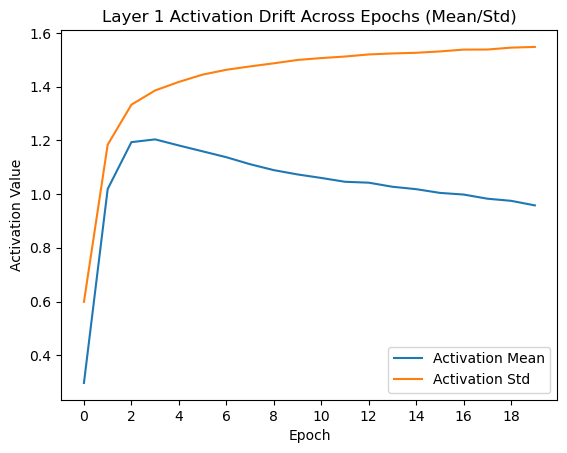

In [180]:
import matplotlib.pyplot as plt

epoch_means = []
epoch_stds = []

for epoch in range(epochs):
    epoch_tensor = torch.cat(layer1_activations[epoch], dim=0)  # shape: [N, neurons]
    epoch_means.append(epoch_tensor.mean().item())
    epoch_stds.append(epoch_tensor.std().item())

plt.plot(epoch_means, label="Activation Mean")
plt.plot(epoch_stds, label="Activation Std")
plt.title("Layer 1 Activation Drift Across Epochs (Mean/Std)")
plt.xticks([i for i in range(epochs) if i % 2 == 0])
plt.xlabel("Epoch")
plt.ylabel("Activation Value")
plt.legend()
plt.show()

#### 3.3.2. Model performance

In [195]:
total = 0
correct = 0

for x, y in test_dataset:
    out = model(x.view(-1, 28*28))
    pred = torch.argmax(out, dim=1)
    if pred == y:
        correct += 1
    total += 1

print(f'Model accuracy: {correct/total*100:.2f}%')

Model accuracy: 94.80%


#### 3.3.3. Hooking gradients

In [810]:
model.eval()
grad_hook = GradientHook(model.linear2)
grad_hook.register()
act_hook = ActivationHook(model.relu2)
act_hook.register()

gradients_by_class = defaultdict(list)
activations_by_class = defaultdict(list)


for x, y in train_dataset:
    model.zero_grad()
    grad_hook.clear()
    act_hook.clear()
    y = torch.tensor([y])

    out = model(x)
    loss = loss_fn(out, y)
    loss.backward()

    act = act_hook.activations[0].squeeze(0).detach()
    activations_by_class[y.item()].append(act)

    grad = grad_hook.gradients[0].squeeze(0).detach()
    gradients_by_class[y.item()].append(grad)

act_hook.clear()
grad_hook.clear()

In [812]:
mean_grads_by_class = defaultdict(list)
mean_acts_by_class = defaultdict(list)

for i in range(10):
    mean_grads_by_class[i].append(torch.stack(gradients_by_class[i]).mean(dim=0))
    mean_acts_by_class[i].append(torch.stack(activations_by_class[i]).mean(dim=0))

In [824]:
for i in range(10):
    top_neurons_grad = torch.topk(mean_grads_by_class[i][0], k=3).indices
    top_neurons_act = torch.topk(mean_acts_by_class[i][0], k=3).indices
    print(f"GRADS: Top neurons for class {i}: {top_neurons_grad.tolist()}")
    print(f"ACTS: Top neurons for class {i}: {top_neurons_act.tolist()}\n")

GRADS: Top neurons for class 0: [0, 12, 7]
ACTS: Top neurons for class 0: [5, 3, 6]

GRADS: Top neurons for class 1: [5, 6, 14]
ACTS: Top neurons for class 1: [0, 2, 7]

GRADS: Top neurons for class 2: [6, 15, 1]
ACTS: Top neurons for class 2: [5, 0, 2]

GRADS: Top neurons for class 3: [14, 13, 12]
ACTS: Top neurons for class 3: [5, 0, 3]

GRADS: Top neurons for class 4: [5, 2, 3]
ACTS: Top neurons for class 4: [6, 13, 12]

GRADS: Top neurons for class 5: [2, 15, 6]
ACTS: Top neurons for class 5: [5, 0, 6]

GRADS: Top neurons for class 6: [12, 3, 1]
ACTS: Top neurons for class 6: [5, 6, 13]

GRADS: Top neurons for class 7: [5, 6, 7]
ACTS: Top neurons for class 7: [3, 12, 13]

GRADS: Top neurons for class 8: [13, 3, 11]
ACTS: Top neurons for class 8: [5, 12, 2]

GRADS: Top neurons for class 9: [11, 0, 14]
ACTS: Top neurons for class 9: [12, 6, 13]



This indicates that neuron 5 is the 'most important' neuron for multiple classes (its a top activator across multiple classes!)... signalling some kind of specialization. We investigate this below with some HEATMAPS to verify this, and then try to understand the feature that it is learning. (quickly looking at the classes it seems likely that it has learned to look for some sort of curvature)

Note also that the gradients in neuron 5 are highest for classes that appear quite different from (0,2,3,5,6,8) Namely things with straight lines (1,4,7). This makes one consider that the gradients are trying to tell us something... maybe something like 

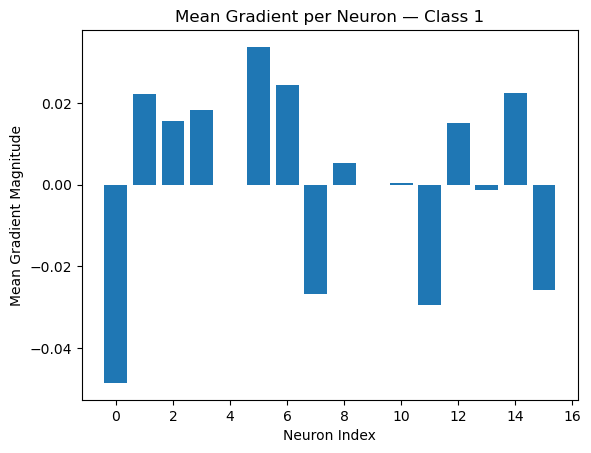

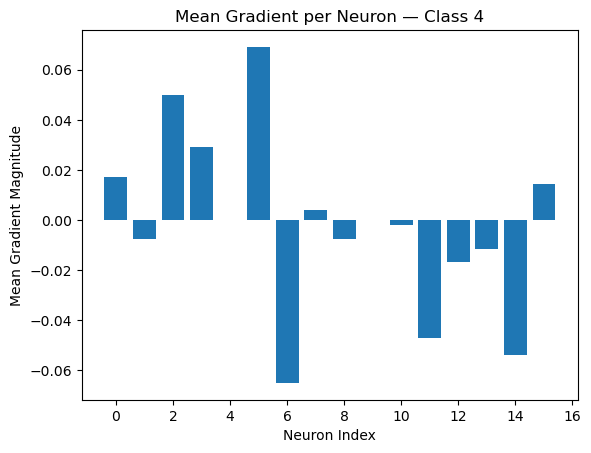

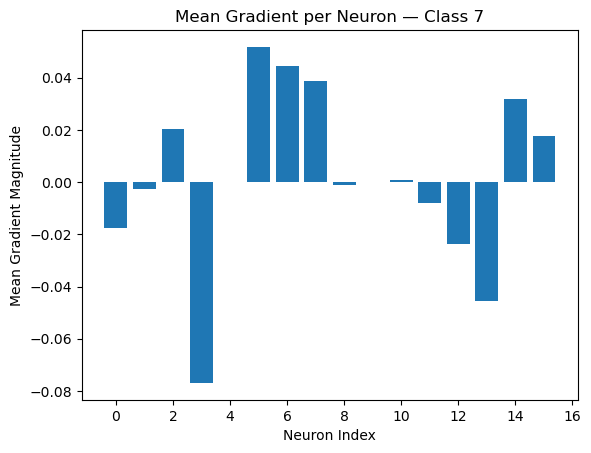

In [835]:
for cls in [1, 4, 7]:
    plt.bar(range(len(mean_grads_by_class[cls][0])), mean_grads_by_class[cls][0])
    plt.title(f"Mean Gradient per Neuron — Class {cls}")
    plt.xlabel("Neuron Index")
    plt.ylabel("Mean Gradient Magnitude")
    plt.show()

---

# 4. Activation/Gradient analysis and visualizations

### 4.0 Helper function for plotting heatmaps

In [689]:
import matplotlib.pyplot as plt
import seaborn as sns

def heatmap(tuple_mean, layer_title):
    plt.figure(figsize=(10,6))
    sns.heatmap(tuple_mean, cmap="viridis", xticklabels=True, yticklabels=True)
    plt.xlabel("Neuron Index")
    plt.ylabel("Class Label")
    plt.title(f"Mean Activations per Class (after {layer_title})")
    plt.show()

### 4.1. Gather activations

The first thing we do is pull out the activations based on class. Note:
> we change the hook in this cell for each of the following cells (plotting the heatmaps)\
> e.g. ```ActivationHook(model.___)``` where ```____ in [output, relu1, relu2]```

In [802]:
hook = ActivationHook(model.relu2)
hook.register()
model.eval()

activations_by_class = defaultdict(list)

with torch.no_grad():
    for x,y in train_dataset:
        hook.clear()

        _ = model(x)

        acts = hook.activations[0].squeeze().detach()
        activations_by_class[y].append(acts)

hook.remove()

### 4.1.1. Compute the (per class) mean activation for each neuron

In [792]:
mean_activations = torch.stack([torch.stack(activations_by_class[cl]).squeeze().mean(dim=0) for cl in range(10)])
mean_activations.shape  # [class, outputs]

torch.Size([10, 16])

### 4.1.2. Quick sanity check...
Our model has been trained to maximize logits on the correct class: we expect the heatmap to be the brightest along the diagonal... as that would indicate that the model achieves a fairly high accuracy. We get about 94.8% accuracy overall (with sligthly better/worse class based performances as indicated above) so the diagonal should light up, and it does. 

In [1258]:
model.eval()

correct = 0
total = 0

for x,y in test_dataset:
    out = model(x)
    pred = torch.argmax(out, dim=1)
    if pred == y:
        correct += 1
    total += 1

print(f'The model achieves an accuracy of {correct/total * 100:.2f}% on test data')

The model achieves an accuracy of 94.80% on test data


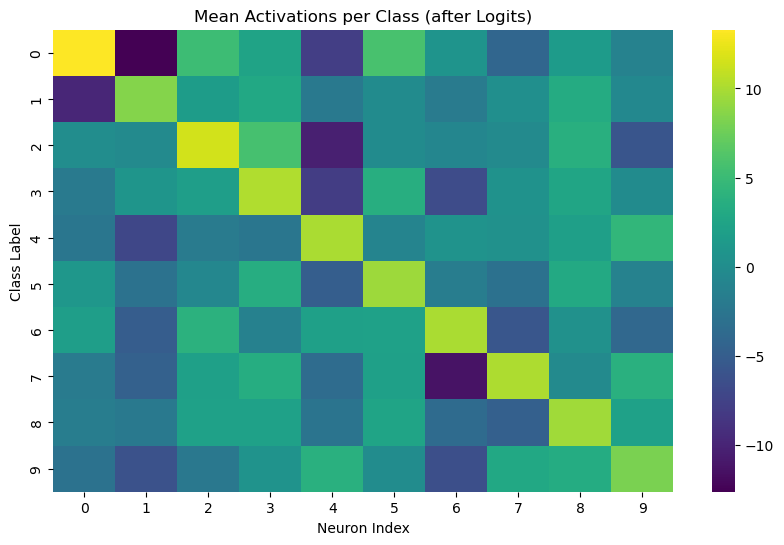

In [695]:
act_mean_np = mean_activations.numpy()

heatmap(act_mean_np, 'Logits')

### 4.2. Investigating internal activations (ReLU layers)
Next we have a slightly more interesting visual that shows mean activations for the ReLU output of the hidden layers. 

In [814]:
print(mean_acts_by_class[0])
mean_activations[0]

[tensor([ 0.9416,  1.5002,  3.0653,  6.7755,  0.0000, 12.1607,  6.1566,  0.7079,
         0.0650,  0.0000,  0.0211,  0.4552,  2.5051,  3.5250,  3.2470,  0.3429])]


tensor([ 0.9416,  1.5002,  3.0653,  6.7755,  0.0000, 12.1607,  6.1566,  0.7079,
         0.0650,  0.0000,  0.0211,  0.4552,  2.5051,  3.5250,  3.2470,  0.3429])

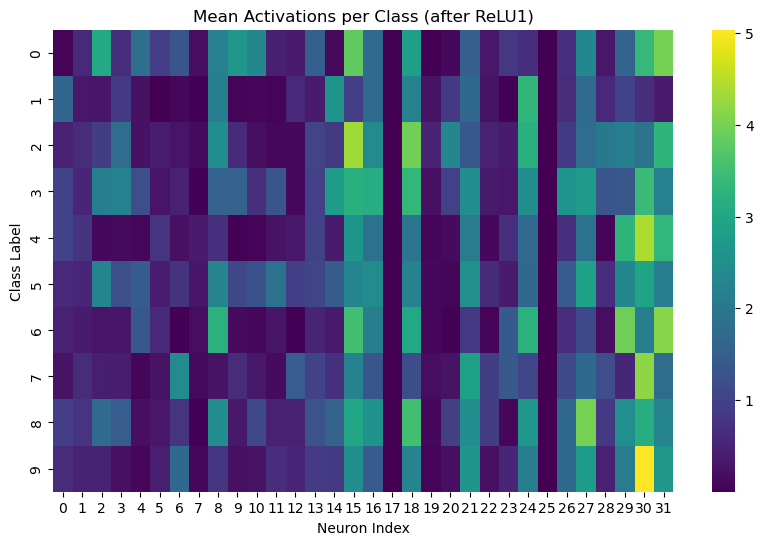

In [713]:
act_mean_np = mean_activations.numpy()

heatmap(act_mean_np, 'ReLU1')

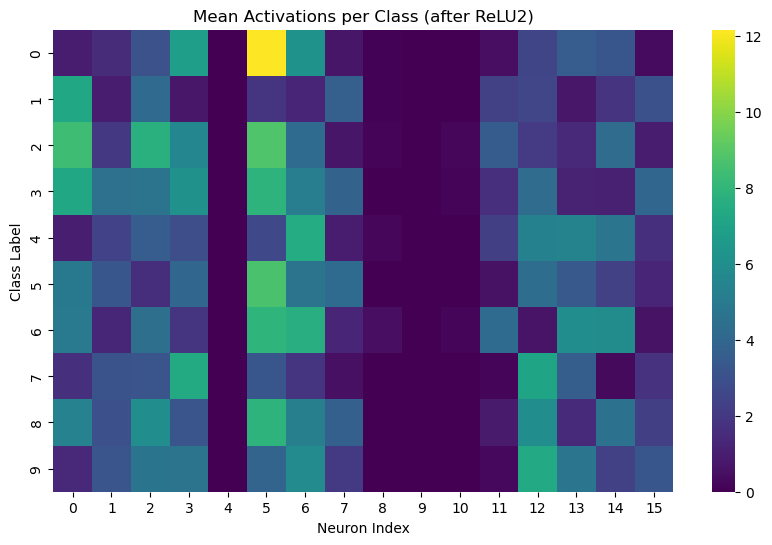

In [687]:
act_mean_np = mean_activations.numpy()

heatmap(act_mean_np, 'ReLU2')

### 4.2.1. Quick thoughts
In Section 3, we noticed that neuron 5 in the second hidden layer stood out — it had high gradients across several classes, suggesting it plays an important role in the network’s predictions about those classes. 

Now, with *activation* heatmaps we see this even more clearly: neuron 5 is consistently active across multiple digit classes, while many other neurons remain mostly inactive (blue columns). I assumed neuron 5 would not be class-specific, but rather encode a cleanly 'interpretable' feature of multiple digits... we explore this idea a bit more below as we refine our tools.

## 4.3. Exploring some visualizations for Neuron 5 in layer 2

### 4.3.1. Gradient based saliency
I did not find this particularly useful, though I did want to try it on some examples. Fun to play with but going to try a 'pixel' activation map next... or, I also found the phrase 'one-hot perturbation' and since I have a paper about 'Adelic perturbations' in number theory I figured I would add that in the next section! :laugh

854


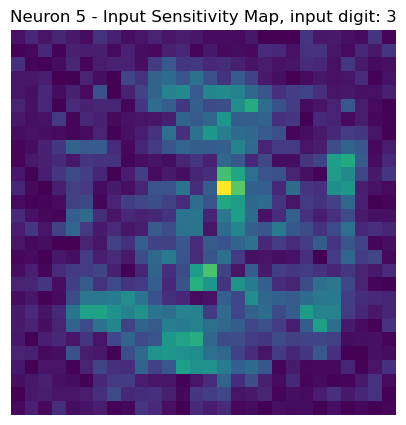

In [1343]:
import matplotlib.pyplot as plt


candidates = []
for x,y in test_dataset:
    if y in [0,2,3,5,6,8]:
        candidates.append((x,y))

i = torch.randint(0, len(candidates), (1,))
print(i.item())

neuron_index = 5  # or whichever you're probing
image = candidates[i.item()][0].clone().unsqueeze(0).requires_grad_(True)  # [1, 1, 28, 28]

# Forward pass to that layer
x = image.view(1, -1)
x1 = model.linear1(x)
x2 = model.relu1(x1)
x3 = model.linear2(x2)  # This is pre-activation
target_neuron_output = x3[0, neuron_index]

# Backprop to input
target_neuron_output.backward()

# Get gradient of neuron 5 wrt input pixels
pixel_gradient = image.grad.data[0, 0]  # shape: [28, 28]

plt.figure(figsize=(5, 5))
plt.imshow(pixel_gradient.abs(), cmap="viridis")
plt.title(f"Neuron {neuron_index} - Input Sensitivity Map, input digit: {candidates[i.item()][1]}")
plt.axis('off')
plt.show()

### 4.3.2. One-hot perturbations

One question we might have had based on the work above is what neuron 5 in the second hidden layer is actually looking at... while we might not have a perfect picture I wanted to highlight one thing. It seemed that neuron 5 was highly active for all numbers that had some 'curvature' so there was some suspicion that it was detecting curves. 

> ***An aha moment (or a duh moment!)***: neuron 5 did not fire as much for class 9 so I wondered.. why that was? 9 seems to have as much curvature as 3, or 6, why wasn't it firing? Well, when I write a 9 I NEVER put a loop on the bottom, it has a (roughly) straight line in there, so why should a curve detector fire on that? The one-hot activation map does show that neuron 5 is looking for anything roughly circular (so with curvature) but not as nice as I had hoped. 

The main question that I have here is what happens when we train with normalization? This single neuron seems to fire for most examples without straight lines... I would like to know if this improves.

In [1156]:
model.eval 

heatmaps = {i: torch.zeros(28, 28) for i in range(16)}

for cl in range(16):
    neuron_index = cl
    heatmap = torch.zeros(28,28)
    
    for i in range(28):
        for j in range(28):
            x = torch.zeros(28, 28)
            x[i,j] = 1.0
    
            with torch.no_grad():
                x1 = model.linear1(x.view(-1, 28*28))
                x2 = model.relu1(x1)
                x3 = model.linear2(x2)
                x4 = model.relu2(x3)
                activation = x4[0][neuron_index]
    
            heatmap[i,j] = activation.item()

    heatmaps[cl] = heatmap

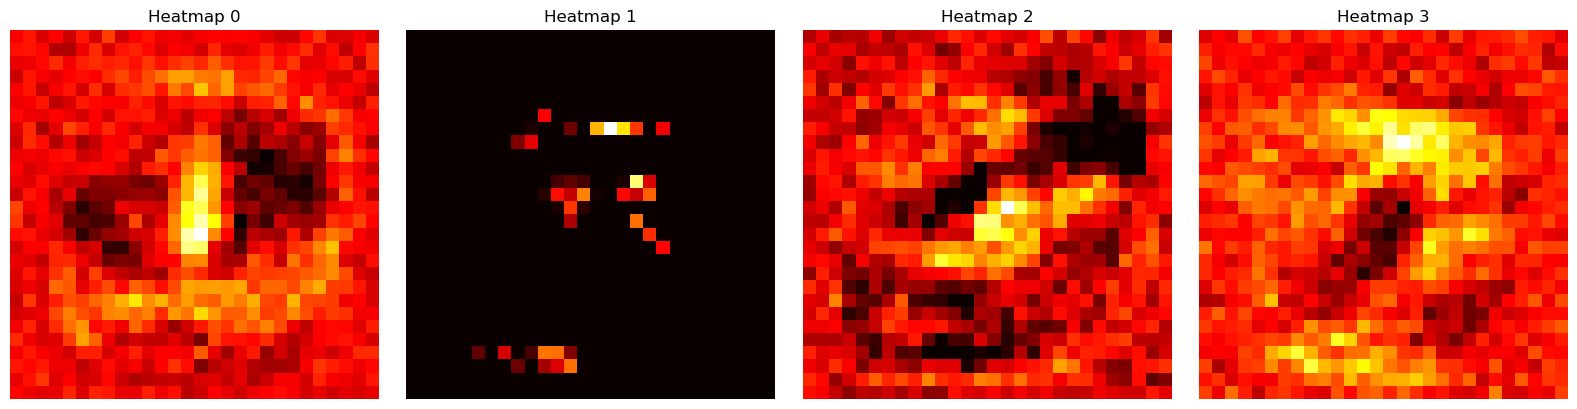

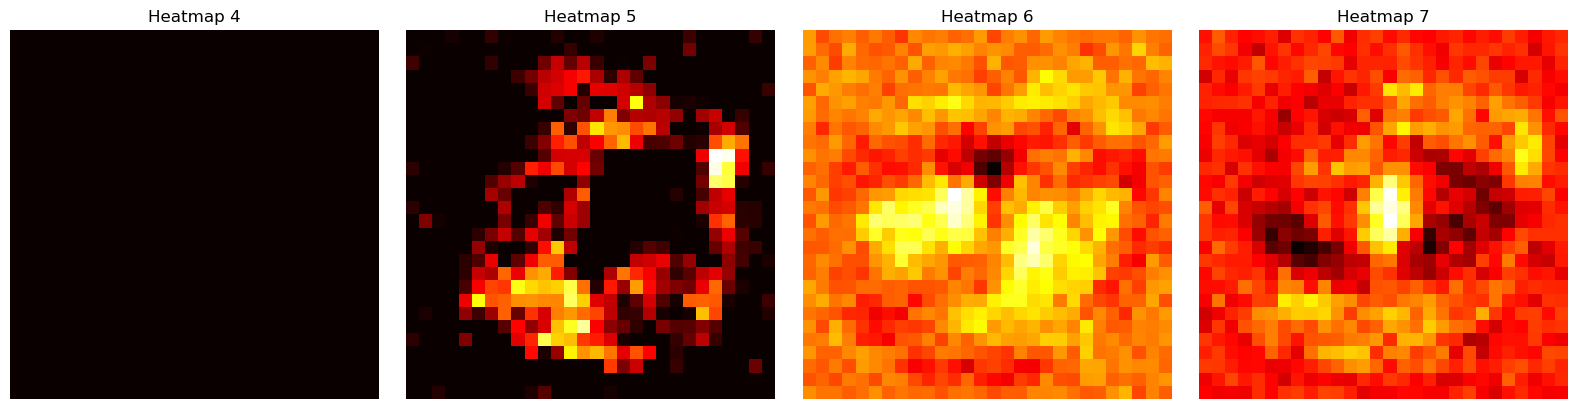

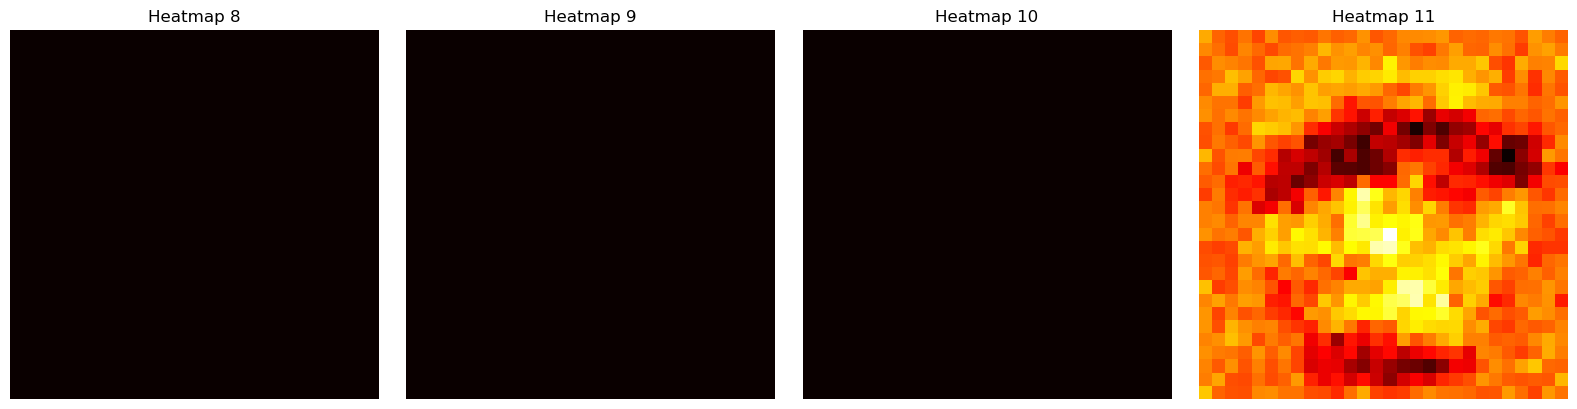

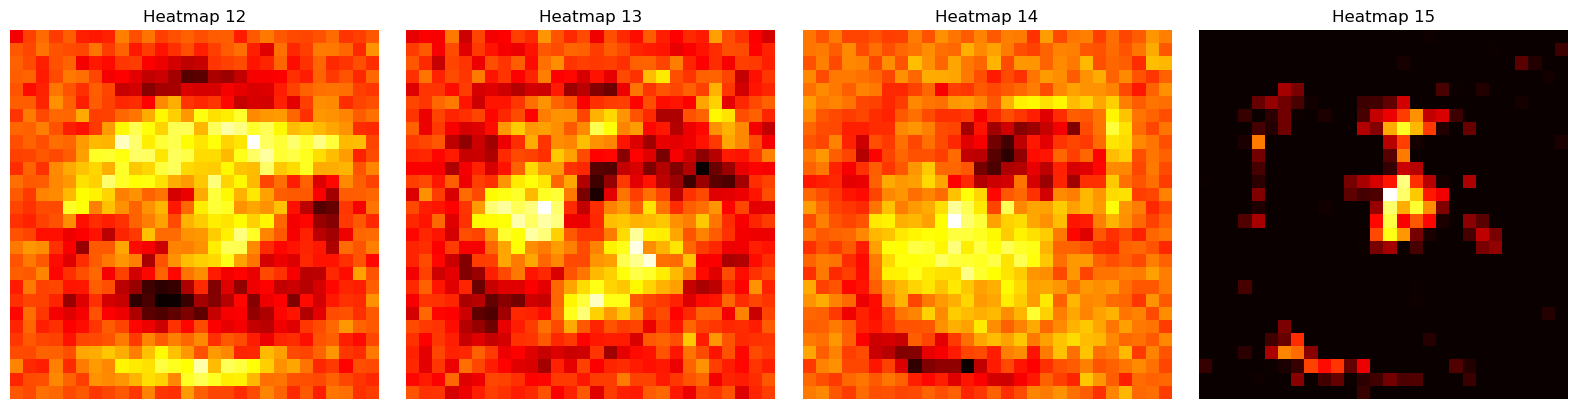

In [1226]:
count = 0
for i in range(4):
    fig, axes = plt.subplots(1, int(len(heatmaps)/4), figsize=(16,4))
    
    for j in range(4):
        axes[j].imshow(heatmaps[count].numpy(), cmap='hot')  # or just `heatmap` if already NumPy
        axes[j].set_title(f'Heatmap {count}')
        axes[j].axis('off')
        count += 1

    plt.tight_layout()
    plt.show()

### 4.3.3. Some reflections
While not exactly accurate we can get some hints from this alone at what might be an important neuron for **certain** classes. For example, neuron 0 seems to really be interested in straight vertical lines through the center of the image... since it seems most likely that a '1' has this feature it is not surprising to scroll up and see that neuron 0 fires most strongly for class '1'... more to come later. 

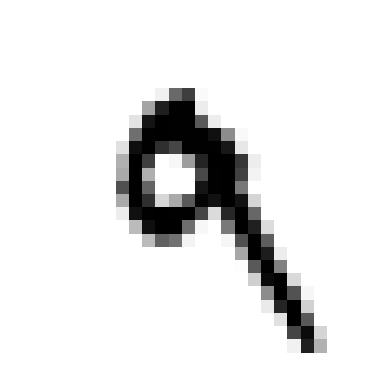

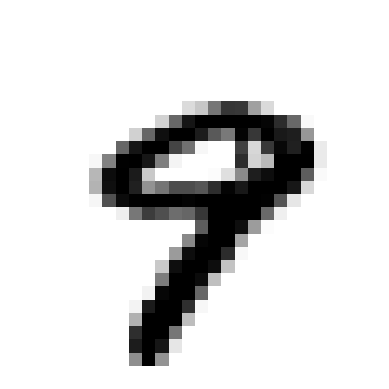

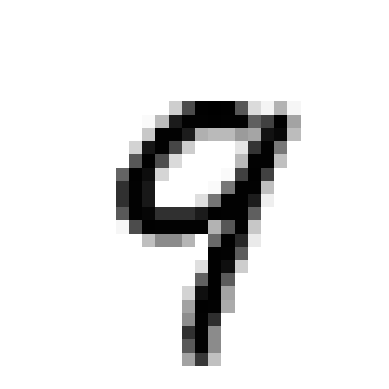

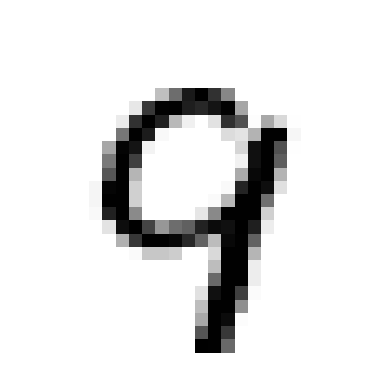

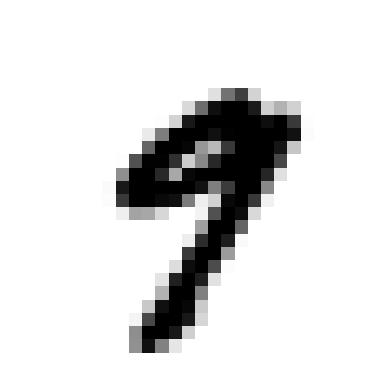

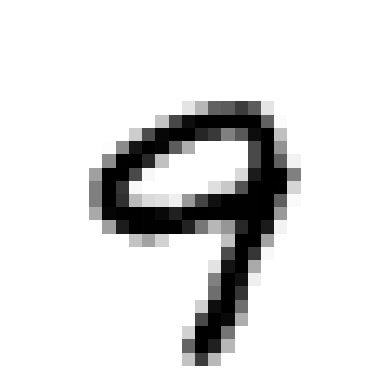

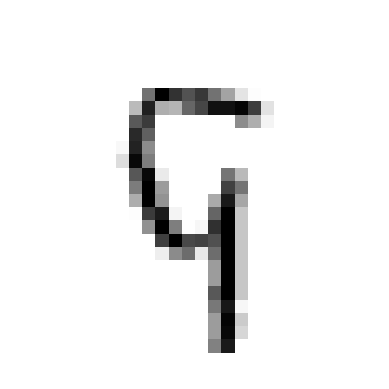

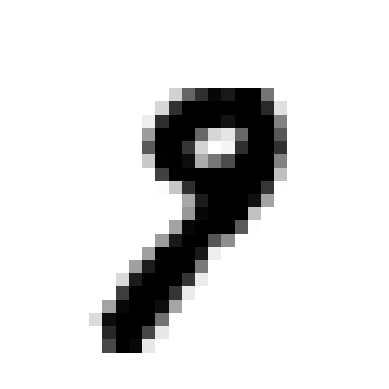

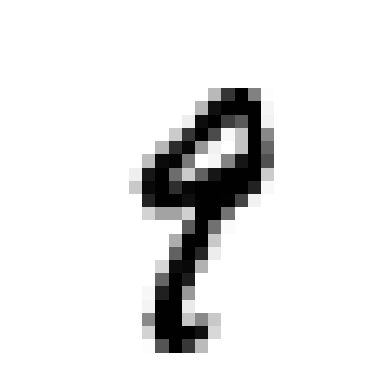

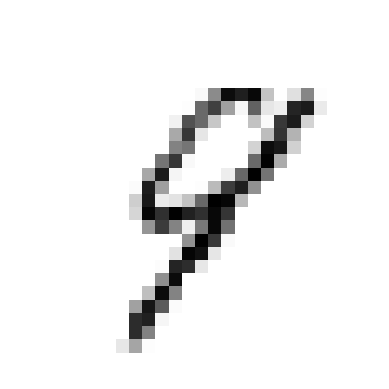

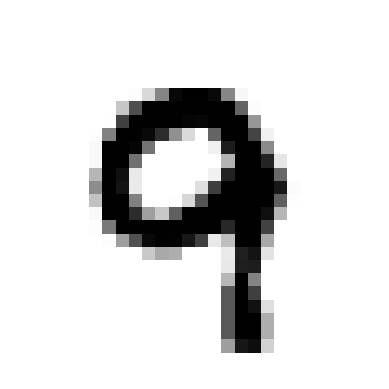

In [1128]:
count = 0
for x, y in test_dataset:
    if count > 10:
        break
    if y == 9:
        plt.imshow(x.squeeze(), cmap='gray_r')
        plt.axis('off')
        count += 1

## 5. The geometry of representation space

In the previous section we saw hints at seemingly 'important' neurons across the hidden layers and we could start to infer behavior of our network using various visualizations. While this was interesting, and we hope more fruitful when normalization enters the picture, we figured the best thing to do now was to use some dimension reduction techniques for a few reasons... to
1) explore these ideas/techniques in a very simple setting
2) visualize (roughly) what activation space looks like in hidden layers.
3) see whether the neurons are learning 'class-separating' features, are classes clustered in obvious ways?
4) etc.
Towards this, lets dive in:

### 5.0. Class accuracy statistics
Since we are going to be visualizing activation representations by class and hope to see cleanly separated classes (or at least observe obvious interactions) we start with our models accuracy across classes. We will reference this below where we analyze roughly what we see in the visualizations

In [1543]:
class_correct = defaultdict(int)
class_total = defaultdict(int)
class_accuracy = defaultdict(float)

model.eval()
with torch.no_grad():
    for x,y in test_dataset:
        out = model(x)
        pred = torch.argmax(out, dim=1)
        if pred.item() == y:
            class_correct[y] += 1
        class_total[y] += 1


for i in range(10):
    class_accuracy[i] = class_correct[i]/class_total[i]*100

descending_accuracy = sorted(class_accuracy.items(), key=lambda x: x[1], reverse=True)

In [1545]:
for y, acc in descending_accuracy:
    print(f'Class {y} accuracy: {acc:.2f}%')

Class 0 accuracy: 98.27%
Class 1 accuracy: 97.80%
Class 4 accuracy: 96.33%
Class 6 accuracy: 95.72%
Class 3 accuracy: 94.55%
Class 7 accuracy: 94.55%
Class 8 accuracy: 93.84%
Class 2 accuracy: 93.51%
Class 5 accuracy: 92.83%
Class 9 accuracy: 90.19%


### 5.1. PCA

#### 5.1.0 Prelude

Principal Component Analysis (PCA) is a *linear* dimension reducing technique that shows up frequently in interpretability research. At its core, it helps us reduce the dimension of a learned representation space so that we can visualize it.

In machine learning — and mathematics — the spaces we work in are often absurdly high-dimensional and hard (impossible?.. for me at least) to visualize directly. So we use to tools like PCA to project these spaces down to something more reasonable for us meremortals-usually 2D or 3D. In my (mathematical) research, I regularly use similar projection techniques to explore complicated structures (if interests are peaked, see the aside below!) but this will be my first time applying PCA to neural network activations, so I’m excited to see what the results look like.


#### 5.1.1 PCA Overview

The basic idea of PCA is to take some high-dimensional data (like the hidden layer activations of a neural network) and find a new set of features (i.e. principal components) that capture as much of the original variation as possible.

To do this, we use linear algebra (woot woot):

1) We start by computing the covariance matrix of the data, which tells us how different features vary/influence each other.
2) We then compute the eigenvalues and eigenvectors of this covariance matrix.
    - The eigenvectors are the principal components: new axes or directions that form an orthogonal basis (i.e. basis vectors form a rectangle in 2D and in general they form a [cuboid](https://en.wikipedia.org/wiki/Cuboid) or *right-rectangular prism*).
    - The eigenvalues tell us how important each direction is — i.e. how much of the data’s variation it explains.
3) We sort the components by importance and project our data onto the top $k$ components, often just 2 for visualization (as below).

**The result**: a (2D) projection of the original high-dimensional space that preserves as much structure as possible.


> There are many good references for PCA, but [this one from GeeksforGeeks](https://www.geeksforgeeks.org/principal-component-analysis-pca/) offers a solid, approachable overview for those who prefer to avoid more formal math :shrug.


<p style="margin: auto; background-color:rgba(300, 0, 0, .1); width: 75%;;  border: 1px solid black; padding: .5em">
 <b> A Mathy Aside</b>: My research involves working with high-dimensional matrices — representing lattices — and studying how these representations vary across structured families. Here we often apply such projections to discard the features shared by all lattices, so we can focus on the more interesting differences.<br>
So while PCA in ML might seem different from PCA in math research, they share a deep geometric intuition — one that I find endlessly fascinating. If I occasionally veer off on such tangents, forgive me. I’m just having fun!*
</p>

#### 5.1.2. Performing PCA
1) run the model and gather activations/labels of the penultimate layer.
2) run PCA (thanks to ```sklearn``` this is trivial)
3) plot the results and see what we get!

In [1443]:
activations = []
labels = []

model.eval()
with torch.no_grad():
    for x,y in test_dataset:
        x1 = model.linear1(x.view(-1, 28*28))
        x2 = model.relu1(x1)
        x3 = model.linear2(x2)
        x4 = model.relu2(x3)
        activations.append(x4)
        labels.append(torch.tensor([y]))

In [1463]:
# concatenate the lists of tensors and covert to numpy array
acts = torch.cat(activations).numpy()
ys = torch.cat(labels).numpy()

In [1469]:
from sklearn.decomposition import PCA

Proj = PCA(n_components=2).fit_transform(acts)

In [1475]:
# Proj contains the projection of the activations in the last hidden layer onto 2D space via PCA.
# Each entry Proj[i] is a 2D point (x, y) representing example i in the reduced space
Proj[1]

array([9.84119  , 5.9141803], dtype=float32)

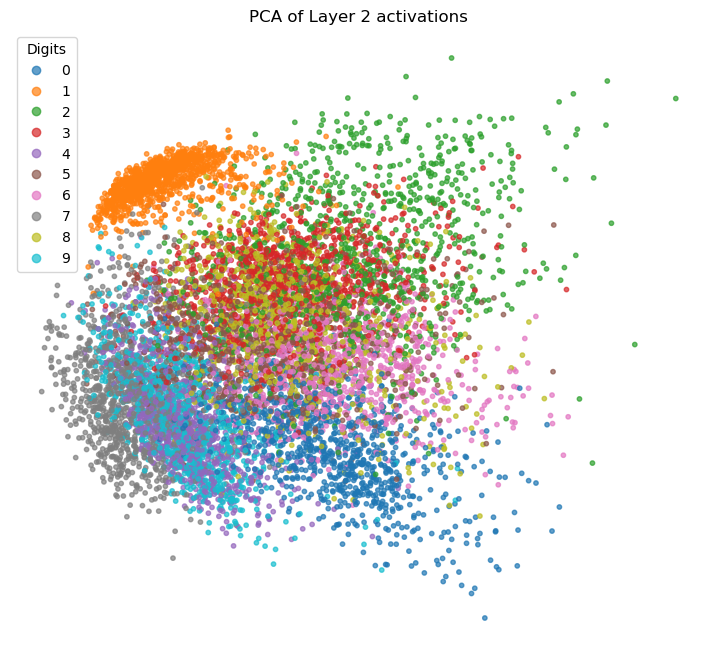

In [1489]:
# Plotting:
plt.figure(figsize=(9,8))
scat = plt.scatter(Proj[:, 0], Proj[:, 1], c=ys, cmap='tab10', s=10, alpha=0.7)
plt.legend(*scat.legend_elements(), title="Digits")
plt.title('PCA of Layer 2 activations')
plt.axis('off')
plt.show()

#### 5.1.3. Some observations
I think this is beautiful... Is it what we would hope for in a perfect world? Probably not — the clusters aren't entirely clean, and there's quite a bit of overlap, but it's not random/meaningless noise either. What we're seeing is a network that's learning to detect shared features across digits — and that's quite fun! Consider this:
- When we (or at least when I) write a **4** versus a **9**, the 9 often looks like a 4 with a hat. So it’s no surprise that these two classes appear close together in the PCA plot.
- The digit **7** lacks some of that structure but still shares partial strokes — and we do see it somewhat near 4 and 9, though with more separation.
- Meanwhile, digits like **3, 5, 6, and 8** often share a loopy lower-right structure (amongst other things) — and sure enough, their embeddings cluster near one another.

These aren’t just random coincidences. The model appears to be building an internal feature space where digits with similar substructures are geometrically close.

The digit **1**, on the other hand, is structurally quite unique — and that’s clearly reflected in the visualization. The ones cluster tightly together at the top of the plot and are fairly well-separated from the rest of the other classes, showing the model has likely found a strong, distinct representation for this class. And, as we see above, the accuracy is quite high for this class. 

#### 5.1.4. A quick experiment
Just wanted to 'see' what is looked like if we took the top 5 classes (in terms of accuracy) and projected only those down.

In [1556]:
top_classes = [0,1,4,6,3]
mask = np.isin(ys, top_classes)

Proj_filtered = Proj[mask]
ys_filtered = ys[mask]

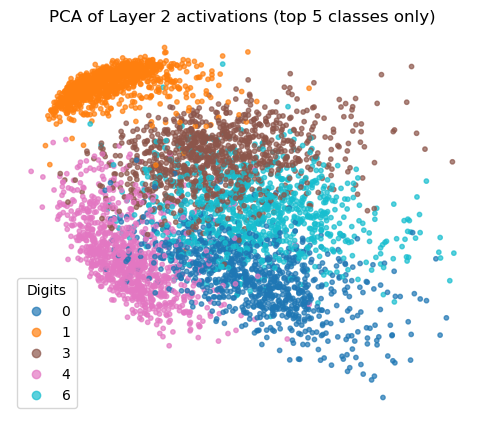

In [1563]:
# Plotting:
plt.figure(figsize=(6,5))
scat = plt.scatter(Proj_filtered[:, 0], Proj_filtered[:, 1], c=ys_filtered, cmap='tab10', s=10, alpha=0.7)
plt.legend(*scat.legend_elements(), title="Digits")
plt.title('PCA of Layer 2 activations (top 5 classes only)')
plt.axis('off')
plt.show()

So... there is a bit of overlap here (unsurprisingly, 3 and 6 seem to have the most significant overlap!) but we do see some pretty clear boundaries! 

> Note: we could/should also try this with the first layer! My assumption is that there would be less clear separation of classes... what do you think??

## 5.2. t-SNE

### 5.2.0. What is t-SNE?
t-distributed Stochastic Neighbor Embedding, or t-SNE, is another popular dimensionality reduction technique used to map high-dimensional data into low-dimensional (often 2D or 3D) space for visualization.

Unlike PCA, which is a linear method, t-SNE is nonlinear, making it better suited for capturing complex spatial relationships — especially in datasets like MNIST, where high-dimensional activations may lie on intricate [manifolds](https://en.wikipedia.org/wiki/Manifold_hypothesis). Instead of projecting the data directly, t-SNE tries to preserve the local 'neighborhood structure' of each point. That is, if two inputs are “close” in the original space, t-SNE tries to keep them close in the projected space as well.

There’s a really nice top-down description of this method by Francisco Castillo in this [blog post](https://arize.com/blog-course/reduction-of-dimensionality-top-techniques/). He walks through the original SNE, improvements in t-SNE, and finally UMAP (which we’ll discuss in the next section).

I highly recommend that post, but here’s a quick summary for future reference:

#### 5.2.1. SNE (*without the t*)

Following the structure laid out in Castillo's post we give the rough steps required for SNE:

**Step 1: compute high dimensional probabilities**
-  Choose a *perplexity* (roughly how many neighbors to consider, usually between 5 and 50). This is used to tune $\sigma_i$, a local scaling factor for each point. (somewhere between 5 and 50... see Francisco's blog post!).
- Compute the scaled euclidean distance between points:
    $$ d_{j|i}^2 = \frac{\| x_i - x_j\|}{2\sigma_i^2}$$
- Next, turn this into a conditional probability (that probability that point $i$ picks point $j$ as its neighbor):
    $$ p_{j|i} = \frac{e^{-d_{j|i}^2}}{\sum_{k\not=i} e^{-d^2_{k|i}}} $$

**Step 2: compute low dimensional probabilities** 
Do the same for the 2D embeddings
    $$ q_{j|i} = \frac{e^{- \| y_i - y_j\|}}{\sum_{k\not= i} e^{-\| y_i - y_k \|}} $$
    
**Step 3: cost function**

- This uses the KL-divergence test to compute the difference between two probability distributions.
    $$ \text{KLDiv} = \sum{P(a)\cdot [\log(P(a)) - \log(P(b))]}$$
In particular we use the cost function defined to be the sum of KL-divergences over all data points:
    $$ C = \text{KL}(P \| Q) = \sum_j \sum_i p_{j|i} \log\left(\frac{p_{j|i}}{q_{j|i}}\right) $$

The idea is to adjust the 2D embeddings $y_i$ so that the low-dimensional 'neighborhood structure' mimics the high-dimensional one. This is done using — yes, you guessed it — gradient descent... welcome back, *GD*!

#### 5.2.2. t-SNE (Again, seriously... just read the blog!) 
The t in t-SNE stands for the [Student-t distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution).\
Everything is basically the same as above, the idea with t-SNE is to make things symmetric. So, in **step 1** we have the symmetric quantity:
    $$ p_{ij} := \frac{p_{j|i} + p_{i|j}}{2n}$$
In **step 2** we use the Student-t distribution with one degree of freedom (i.e.e the Cauchy distribution, rather than the [Guassian kernel](https://www.geeksforgeeks.org/machine-learning/gaussian-kernel/)) to obtain:
    $$ q_{ij} = \frac{(1 +  \| y_i - y_j\|^2)^{-1}}{ \sum_{i\not= k} (1 + \| y_i - y_k\|^2)^{-1}}$$
And finally, the cost function is:
    $$ C = \sum_j \sum_i p_{ij} \ln\left(\frac{p_{ij}}{q_{ij}}\right) $$

### 5.2.3. Applying t-SNE 
The nice thing is that to do this we only need a few lines of code, basically ported over exactly as we did with PCA! 
> t_SNE, however, takes a fair bit more time! (consider reading the UMAP section of Franscisco's post as this runs!)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=20, init='pca', learning_rate='auto')

Proj_tsne = tsne.fit_transform(acts)

In [ ]:
Proj_tsne[0]

In [ ]:
# NEXT STEP... (after the t-SNE runs... it is SLOW) plot like we did above:
plt.figure(figsize=(6, 5))
scatter = plt.scatter(Proj_tsne[:, 0], Proj_tsne[:, 1], c=ys, cmap='tab10', s=10, alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title(f"t-SNE of layer 2 activations")
plt.axis('off')
plt.show()